Batches: 100%|██████████| 199/199 [00:04<00:00, 41.42it/s]


(6353, 384)
(6353, 2)


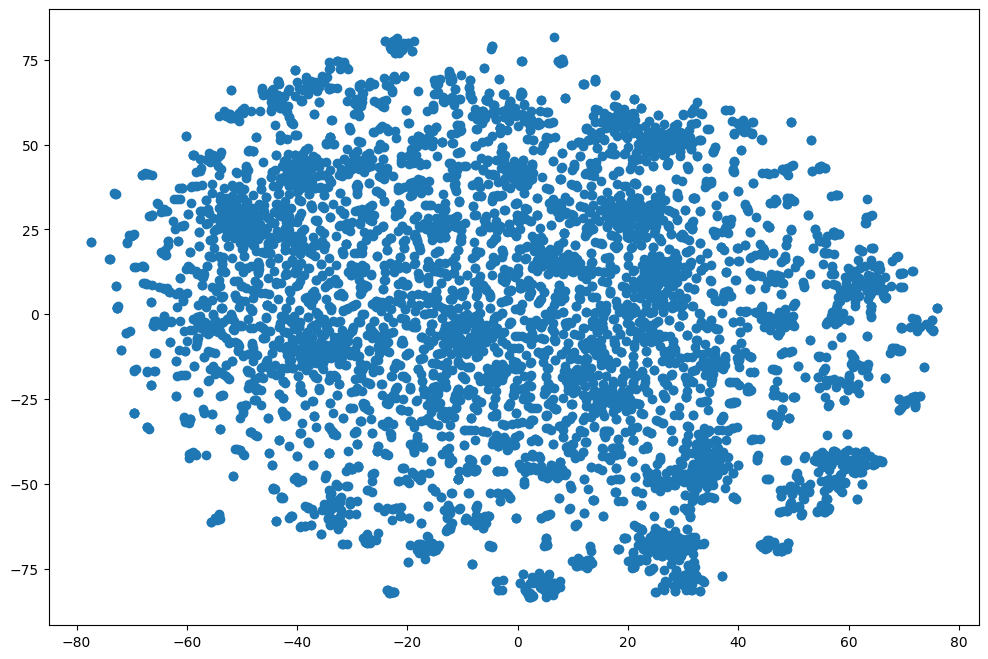

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer


# Load data
SEP = "\n----------\n"
filename = "strings"
with open(f"data/{filename}.txt", 'r') as f:
    strings = f.read()

strings = list(set(list(map(lambda x: x.strip("f").strip("\"'").strip(), strings.split(SEP)))))


# Step 1: Generate Embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(strings, show_progress_bar=True)
embeddings = np.array(embeddings)
print(embeddings.shape)

# Step 2: Reduce Dimensionality with t-SNE
tsne = TSNE(n_components=2)
embeddings_reduced = tsne.fit_transform(embeddings)
print(embeddings_reduced.shape)

# Step 3: Plotting
x_coords = embeddings_reduced[:, 0]
y_coords = embeddings_reduced[:, 1]
plt.figure(figsize=(12, 8))
plt.scatter(x_coords, y_coords)

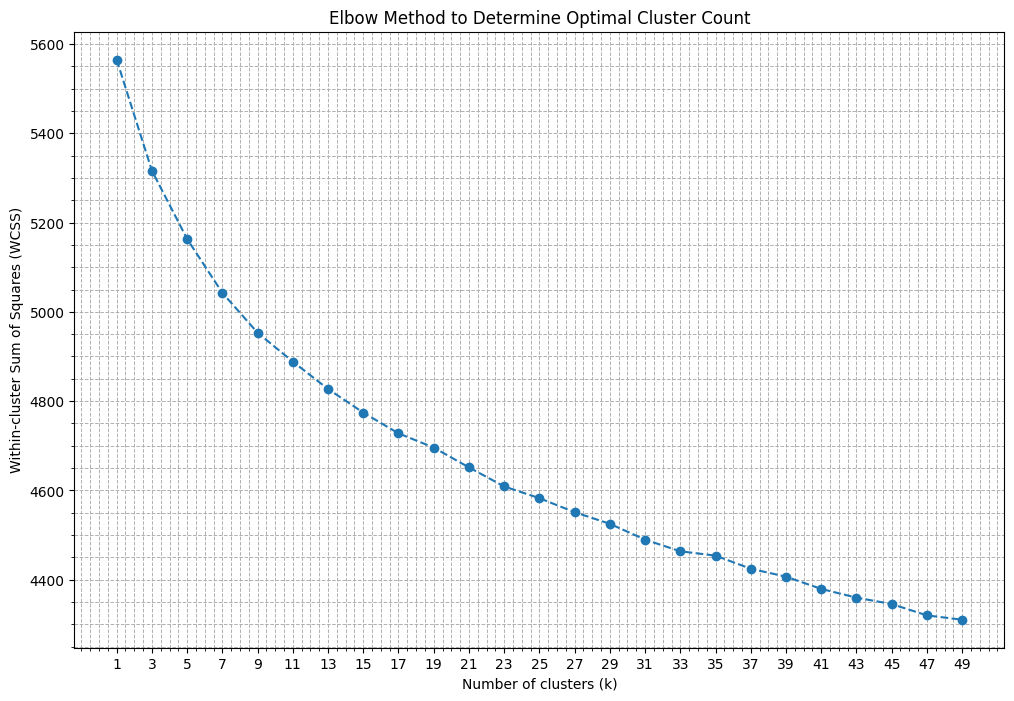

In [23]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Initialize the list to hold the within-cluster sum of square values
wcss = []

# We might want to test a range of k values; I'll choose from 1 to 15
k_clusters = range(1, 50, 2)
for i in k_clusters:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=10, random_state=0)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS for that model
    if i % 10 == 0:
        print(f'Finished {i} clusters')

# Now time to craft our plot with elbow grease
plt.figure(figsize=(12, 8))
plt.plot(k_clusters, wcss, marker='o', linestyle='--')

# Let's make it look top-notch, follow the material design principles for crisp visuals
plt.title('Elbow Method to Determine Optimal Cluster Count')
plt.xlabel('Number of clusters (k)')
plt.xticks(k_clusters)
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.minorticks_on()
plt.savefig(f"images/{filename}_elbow.png")
plt.show()

/tmp/ipykernel_31952/2301322742.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('turbo', k_optimal)  # 'tab10' provides nice distinct colors


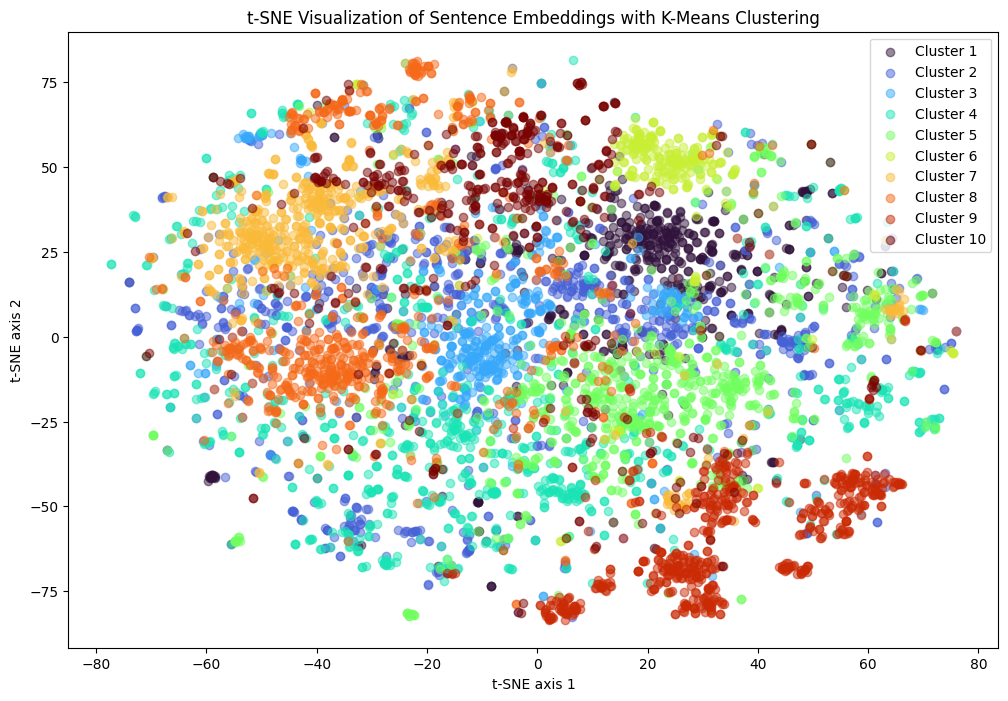

In [26]:
# Let's assume k_optimal is the optimal cluster count we selected from the elbow plot
k_optimal = 10  # Replace this with the actual optimal number of clusters you have observed

# Now run the K-Means algorithm with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=k_optimal, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans_optimal.fit_predict(embeddings)

# Then we visualize using a palette that has a nice variety of distinct colors
palette = plt.cm.get_cmap('turbo', k_optimal)  # 'tab10' provides nice distinct colors
plt.figure(figsize=(12, 8))

# Scatter plot with color coding for each cluster
for i in range(k_optimal):
    plt.scatter(x_coords[cluster_labels == i], y_coords[cluster_labels == i], label=f'Cluster {i+1}', c=[palette(i)], alpha=.5)

# Shining the spotlight on good design – a must for great UX
plt.title('t-SNE Visualization of Sentence Embeddings with K-Means Clustering')
plt.xlabel('t-SNE axis 1')
plt.ylabel('t-SNE axis 2')

# Add that crisp legend, positioned so it doesn’t smudge our plot
plt.legend()

# And display!
plt.savefig(f"images/{filename}_clusters.png")
plt.show()

In [27]:
# Make cluster to prompt map
cluster_to_prompt = {}
for i in range(k_optimal):
    cluster_to_prompt[i] = []
    for j in range(len(strings)):
        if cluster_labels[j] == i:
            cluster_to_prompt[i].append(strings[j])

# Save cluster to prompt map
import json
with open('data/cluster_to_prompt.json', 'w') as f:
    json.dump(cluster_to_prompt, f)